# *Predicting Graduate Admissions using Random Forest*
#### Authors: Tom Sharp 


## Agenda ##
Part 1: Data Import, Exploration, and Cleaning <br>
Part 2: Decision Tree - The Building Block of Random Forest <br>
Part 3: Random Forest <br>
Part 4: Feature Importance <br>
Part 5: Over/Under Fitting <br>
Part 6: Tuning the Forest

<br>
## Part 0: Environment Setup

In [2]:
# Import the os library, the pandas library (aliased as pd), and the numpy library (aliased as np)

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
print(os.getcwd())

C:\Users\tomsharp\Desktop\Firm Initiatives\Demystifying_ML\random_forest


In [4]:
"Data for this notebook was obtained at {} ".format('https://www.kaggle.com/malapatiravi/graduate-school-admission-data')

'Data for this notebook was obtained at https://www.kaggle.com/malapatiravi/graduate-school-admission-data '

In [5]:
# Store the paths to frequently used files

parent_path = os.getcwd()
data_path = os.path.join(parent_path,  'data', 'college_admissions.csv')
image_path = os.path.join(parent_path, 'images')


print(parent_path)
print(data_path)
print(image_path)

C:\Users\tomsharp\Desktop\Firm Initiatives\Demystifying_ML\random_forest
C:\Users\tomsharp\Desktop\Firm Initiatives\Demystifying_ML\random_forest\data\college_admissions.csv
C:\Users\tomsharp\Desktop\Firm Initiatives\Demystifying_ML\random_forest\images


## Part 1: Data Import, Exploration, and Cleaning

During any analysis, it is always important to first examine your data. This involves looking at the data itself, the column names, and some summary statistics about the data.

In [6]:
# Read in the data using the pandas package. The data is stored in what is called a dataframe (similar to a spreadsheet)

data = pd.read_csv(data_path)

In [7]:
# Examine number of rows and columns 

print("num of rows, num of columns = ", data.shape)

num of rows, num of columns =  (400, 4)


In [8]:
# That's a lot of rows. Let's just look at the first three columns of the data, instead of all of them

data.head(10)

,gre,gpa,rank,admit
0,380,3.61,3,0
1,660,3.67,3,1
2,800,4.00,1,1
3,640,3.19,4,1
4,520,2.93,4,0
5,760,3.00,2,1
6,560,2.98,1,1
7,400,3.08,2,0
8,540,3.39,3,1
9,700,3.92,2,0


In [9]:
# We can list all the column names by calling the "columns" attribute of "data" 
# Def: Attribute - describes the data (an adjective)

print(list(data.columns))

['gre', 'gpa', 'rank', 'admit']


In [10]:
# these column names could be a bit more specific - let's rename them

data.columns = ['gre_score', 'undergrad_gpa', 'undergrad_school_rank', 'admitted']

In [11]:
# We can view summary statistics about the data by calling the "describe()" method of "data"
# Def: Method - take an action on the data (a verb)

print(data.describe())
print('\n')
print("Number of students admitted = {}".format(sum(data['admitted']==1)))
print("Number of students NOT admitted (rejected) = {}".format(sum(data['admitted']==0)))

        gre_score  undergrad_gpa  undergrad_school_rank    admitted
count  400.000000     400.000000              400.00000  400.000000
mean   587.700000       3.389900                2.48500    0.317500
std    115.516536       0.380567                0.94446    0.466087
min    220.000000       2.260000                1.00000    0.000000
25%    520.000000       3.130000                2.00000    0.000000
50%    580.000000       3.395000                2.00000    0.000000
75%    660.000000       3.670000                3.00000    1.000000
max    800.000000       4.000000                4.00000    1.000000


Number of students admitted = 127
Number of students NOT admitted (rejected) = 273


**This value, *admitted*, is what we would like to predict using a machine learning. Before we can predict, we need to make sure we clean the data.**

In [12]:
# check for NAs, NaNs, etc. 
any(data.isnull().sum(axis=1))

False

In [13]:
# Clean the data - fortunately, someone did this for us

print("Data clean!")

Data clean!


*Side Note - In most applications of data science and ML, we would take a closer look at cleaning the data. Data gathering and cleansing usually consumes +80% of the DS/ML process; however, this dataset happened to be extremely clean when it was retrieved from its source online.*

In [14]:
data.head()

,gre_score,undergrad_gpa,undergrad_school_rank,admitted
0,380,3.61,3,0
1,660,3.67,3,1
2,800,4.00,1,1
3,640,3.19,4,1
4,520,2.93,4,0


## Part 2: Decision Tree - The Building Block of Random Forest

<img src="images/tree_joke.jpg" height="500" align="center"/>


### Conceptual Introduction

In machine learning, the columns to be used as inputs (X) are referred to as the **features**, and the output (y) value is referred to as the **target** or the **label**.
<br>

Since we are given the target/label values in this dataset, the type of machine learning we will be doing is called **supervised**. 
<br>
In particular, we will be using a random forest. Before we jump into that, we need to understand the basic building block of that model, known as the decision tree. 
<br>
<br>
A decision tree is one of the easiest machine learning model to comprehend, since it is easily visualized. The below graphic is an example of a simple decision tree. Notice that each *node* contains a yes/no question, and each *branch* leads to a new node, unless it leads to an answer. These answers are called *leaves* or *leaf nodes*.

<img src="images/decision_tree_example.jpg" width="500" height="500" align="center"/>

How are these questions determined? The decision tree is given several features (inputs) and determines which questions to ask to *gain the most information from the oucome*, i.e., to increase **information gain**. You can think of a decision tree like a game of *Guess Who?*. Each round, you ask one question in order to get the most information out of the opposite player. 
<br>
<br>
For example, a popular first round question is, *"Is your character a man or woman?"*. This gives you a lot more information than asking *"Is your character Joe?"*.

<img src="images/guess_who.jpg" width="500" height="500" align="center"/>

### Splitting the Data

In order to perform supervised learning, we will **train** (aka, fit) our model, and then **test** our model to see how accurate it is. We do this by first dividing the data into the **training data** and the **testing data**. In order for our model to be trained adequately, we would like it to have as much data as possible. Therefore, we take 80% of our current dataset to be the training data, and the remaining 20% to be the testing data. This is somewhat arbitrary, but the split usually lies around 75 / 25 or 80 / 20. 
<br>

Also recall from above that the input (X) values are referred to as **features** and the output (y) values are referred to as **targets** or **labels**. We need to store the columns in our dataset into these variables before we can split our data.


<img src="images/splitting_data.png" width="700" height="700" align="center"/>

We will first split our data into **feaures** and **labels**, and then **training data** and **testing data**.

*Features vs. Labels*

In [15]:
list(data.columns)

['gre_score', 'undergrad_gpa', 'undergrad_school_rank', 'admitted']

In [16]:
# Convert to numpy arrays - these are similar to dataframes but have less structure. sklearn can only take numpy arrays

# Drop the cmedv column - the features are all the columns except this one
feature_names = ['gre_score', 'undergrad_gpa', 'undergrad_school_rank']
features = data[feature_names]
features = np.array(features)


print("FEATURES")
print("shape: ", "\n", features.shape)
print("first five rows: ", "\n", features[:5])

FEATURES
shape:  
 (400, 3)
first five rows:  
 [[380.     3.61   3.  ]
 [660.     3.67   3.  ]
 [800.     4.     1.  ]
 [640.     3.19   4.  ]
 [520.     2.93   4.  ]]


In [17]:
# Drop all columns that aren't cmedv - cmedv is the only label
label_names = ['admitted']
labels = data[label_names]
labels = np.array(labels)
labels = labels.reshape([400,])

print("LABELS")
print("shape: ", "\n", labels.shape)
print("first five rows: ", "\n", labels[:5])

LABELS
shape:  
 (400,)
first five rows:  
 [0 1 1 1 0]


*Training Data vs. Testing Data*

In [18]:
# Use scikit-learn to split the data and store the data into variables. 
# Notice we specify test_size = 0.2. This gives the 80/20 split as explained above

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 1)

### The Supervised Learning Approach

As we know, a decision tree is a supervised learnin model, since we have labels that help the algorithm learn. The following picture depicts the supervised learning approach.

<img src="images/Supervised_Learning.png" width="700" height="700" align="center"/>


### Step 1: Train the Model

Sci-kit learn 3 lines of code to Train the Model

In [19]:
# import
from sklearn import tree

# instantiate 
decision_tree = tree.DecisionTreeClassifier(random_state = 8)

# train/fit
decision_tree = decision_tree.fit(X_train, y_train)

Let's see what our *Trained Model* looks like by converting the tree into an image.

In [19]:
# tree.export_graphviz(decision_tree, out_file='tree_clf.dot')

In [20]:
# # View picture after converting to png (I did this for you already)
# !"images/tree_clf.png"

*Side-Note: To convert this dot file on your own, you need to use some command line magic I converted the file beforehand, so you can view the tree by running this code block.
For anyone interested, the command line function is below (make sure you are cd'd into the random_forest/images directory and are in the dm_ml environment)*

> [In Python.....] tree.export_graphviz(decision_tree, out_file='tree_clf.dot')
<br>
>[In CMD Line] *dot -Tpng tree_clf.dot -o tree_clf.png*

### Step 2: Test the Model

Here, we will use the labels from the testing data to generate predictions on the admissions. Let's see what the model comes up with.

In [21]:
# Use the forest's predict method on the test data
tree_predictions = decision_tree.predict(X_test)

# Format and print
tree_predictions = pd.Series(tree_predictions)
pd.DataFrame(data = {'predicted value': tree_predictions, 'actual value':list(int(val) for val in y_test)}).head(10)

,predicted value,actual value
0,0,0
1,1,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,1
7,1,0
8,1,0
9,0,1


<br>
As you can see, the predicted values differ from the y_values for each row; the accuracy of each row differs. To better understand our model's performance, however, we want to view a few different measures. 

### Step 3: Measure the Model's Performance

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy = accuracy_score(y_true=y_test, y_pred=tree_predictions)

print("Accuracy = {}%".format(accuracy*100))

Accuracy = 60.0%


While this decision tree is quite accurate, we can possibly improve accuracy using the random forest model. The random forest model essentially builds multiple decision trees, takes the outputs from all of those trees, and determines the best prediction by taking the average (regression) or the mode (classification) of the outputs

## Part 3: Random Forest

<img src="images/random-forest.jpg" width="700" height="700" align="center"/>


The random forest is an **ensemble model** i.e., it combines multiple models into one larger model. By combining multiple decision trees, the random forest is able to improve the prediction accuracy. 

<br> The random forest combines multiple decision trees by using a concept called **bootstrap aggregating**, or **bagging** for short. This method builds multiple (usually 1,000's) decision trees during the *Train the Model* step. When we *Test the Model*, each decision tree predicts the output and the random forest combines all the outputs into a *single* output. It does this by either taking a majority vote (in classification) or by aggregating the values (in regression, which is our case) by use of a mean, median, etc. 

This is all done behind the scenes within sklearn. The same 3-step process is used (recall that the data was originally split above).

### Step 1: Train the Model

Again, we import, instantiate, and then fit
<br>
Here, n_estimators is the number of decision trees in our random forest

In [24]:
# import 
from sklearn.ensemble import RandomForestClassifier

# instantiate 
rf = RandomForestClassifier(n_estimators = 1000, random_state = 10)

# train/fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

### Step 2: Test the Model

In [25]:
# Now let's predict and see the predictions next to the actual y values

# predict
rf_predictions = rf.predict(X_test)

# format and print
pd.DataFrame(data = {'predicted values':rf_predictions, 'actual value': list(int(val) for val in y_test)}).head(10)

,predicted values,actual value
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,1
7,1,0
8,0,0
9,0,1


### Step 3: Measure the Model's Performance

In [26]:
accuracy = accuracy_score(y_true=y_test, y_pred=rf_predictions)
print("Accuracy = {}%".format(accuracy*100))

Accuracy = 72.5%


As shown here, our Random Forest "out of the box" improved our accuracy over the Decision Tree "out of the box". Ensemble models are known to improve accuracy. 

HOwever....

Why accuracy *alone* is not a great measure of a model:
<br>
https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/

<img src="images/conf_matrix.jpeg" width="600" align="center"/>

<br>
We can view the Confusion Matrix for our model using sklearns confusion_matrix function

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=tree_predictions)

array([[35, 16],
       [16, 13]], dtype=int64)

<br>
We can plot this for easier viewing using a function from sklearn's website <br>
This function provided by sklearn - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [28]:
from util import plot_confusion_matrix

None


Confusion matrix, without normalization
[[35 16]
 [16 13]]


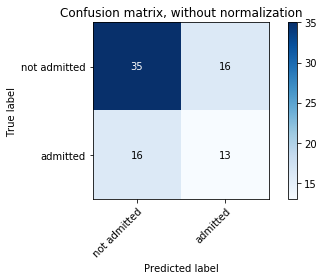

In [29]:
plot_confusion_matrix(y_true=y_test , y_pred=tree_predictions, classes=['not admitted','admitted'])

Using the Confusion Matrix, we can calculate other values to measure our model's performance
<br><br>
Reference and further Reading on this topic - *Highly Recommend*
<br>
https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

<img src="images/precision_recall.png" width="300" align="center"/>
<img src="images/f1_score.png" width="250" align="center"/>

In [30]:
from sklearn.metrics import classification_report 

In [31]:
report = classification_report(y_true=y_test, y_pred=tree_predictions, target_names=['not admitted', 'admitted'])
print(report)

print('*Note: Support is simply the number of data points used in the calculations - \n       i.e., the number of data points in the test dataset')

              precision    recall  f1-score   support

not admitted       0.69      0.69      0.69        51
    admitted       0.45      0.45      0.45        29

   micro avg       0.60      0.60      0.60        80
   macro avg       0.57      0.57      0.57        80
weighted avg       0.60      0.60      0.60        80

*Note: Support is simply the number of data points used in the calculations - 
       i.e., the number of data points in the test dataset


Although we see that simply using Random Forest is better than a single decision tree, there is still room for improvement. These next 2 sections will show you some techniques to both simplify and tune your model in order to improve its accuracy.

## Part 4: Feature Importance

Let's see which factors of a candidate influence his/her chances of being admitted. We can do this using a few more complex techniques in Python. 
<br>

I won't be getting into these and I am also going to use some code that was written by William Koehrsen in his article that can be found here: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [32]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: undergrad_gpa        Importance: 0.52
Variable: gre_score            Importance: 0.37
Variable: undergrad_school_rank Importance: 0.11


It looks like the candidate's Undergraduate GPA makes up about 50% of the decision on whether they will be admitted or not, and Undergraduate School Rank only accounts for 15% of the decision. <br>
Does this make sense? It is always improtant to look at your model output and determine if it logically matches the context of the problem

In [33]:
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.round(np.cumsum(sorted_importances),2)

importance_df = pd.DataFrame({'features': sorted_features, 'importance': sorted_importances, 'cumulative importance': cumulative_importances})
importance_df

,features,importance,cumulative importance
0,undergrad_gpa,0.52,0.52
1,gre_score,0.37,0.89
2,undergrad_school_rank,0.11,1.00


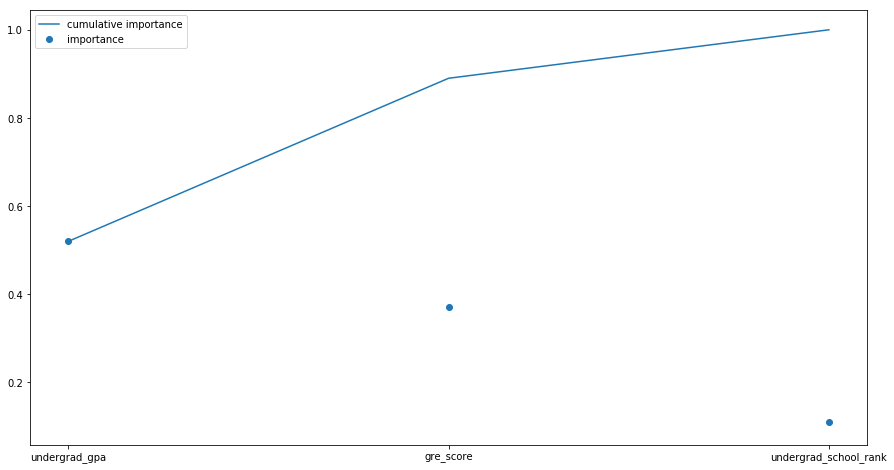

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

features = importance_df['features']
importance =  importance_df['importance']
cumulative_importance = importance_df['cumulative importance']


fig, ax = plt.subplots(figsize = (15,8))
ax.scatter(features, importance, label="importance")
ax.plot(features, cumulative_importance, label="cumulative importance")
ax.legend()

plt.show()

This is more important when we have high-dimensional data (many features). For a better example, reference the regression notebook.

### ***TODO - add in example here

## Part 5: Over/Under Fitting

What happens if we use our trained model on the training set of the data?

In [35]:
predictions_training = rf.predict(X_train)

accuracy = accuracy_score(y_true=y_train, y_pred=predictions_training)
print("Accuracy = {}%".format(accuracy*100))

print('\n')

report = classification_report(y_true=y_train, y_pred=predictions_training, target_names=['not admitted', 'admitted'])
print(report)

Accuracy = 99.0625%


              precision    recall  f1-score   support

not admitted       0.99      1.00      0.99       222
    admitted       0.99      0.98      0.98        98

   micro avg       0.99      0.99      0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



By fitting the model "out of the box", we allowed the tree to grow as large as possible (we can see this because there was almost no error when it predicted the y values for the training data... the model predicted almost every y value exactly).This behavior is known as **overfitting**.

Overfitting is when the model follows the *"noise"* of the **training data** too closely, and therefore won't predict general input data later on. <br>
http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

<img src="images/overfitting_underfitting.png" width="700" height="700" align="center"/>

There are ways to combat overfitting by tuning the model. One way to do this is decrease the depth of each tree (either before or after fitting - research *pruning*).

Let's create several RF models, each with a different max_depth input. We can see how each of these performs to determine which of the models are overfitting.

In [36]:
max_depths = list(range(3,15))

In [37]:
from sklearn.metrics import f1_score

accuracy_list=[]
test_f1_list=[]

for depth in max_depths:
    ## import - already done

    ## instantiate 
    rf = RandomForestClassifier(max_depth = depth, n_estimators = 1000, random_state = 10)

    ## train/fit
    rf.fit(X_train, y_train)
    
    # predict on the training data 
    predictions_training = rf.predict(X_train)
    predictions_testing = rf.predict(X_test)
    
    # f1 score for test set 
    test_f1 = f1_score(y_true=y_test, y_pred=predictions_testing)
    test_f1_list.append(test_f1)

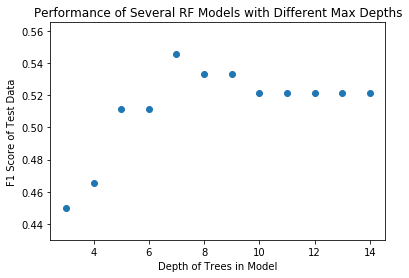

In [38]:
plt.scatter(x=max_depths, y=test_f1_list)
plt.title("Performance of Several RF Models with Different Max Depths")
plt.xlabel("Depth of Trees in Model")
plt.ylabel("F1 Score of Test Data")
plt.show()

The performance (f1 score) of the testing data helps us which models are overfitting. The inflection point at Depth of Tress in Model = 7 shows us that our Random Forest models with max_depth greater than 7 will overfit the data and therefore perform lower.

In [39]:
#n_estimators

Let's build a RF with max_depth = 7 

In [41]:
## import - already done

## instantiate 
rf = RandomForestClassifier(max_depth = 7, n_estimators = 1000, random_state = 10)

## train/fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [42]:
rf_predictions = rf.predict(X_test)

Confusion matrix, without normalization
[[48  3]
 [17 12]]
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        51
           1       0.80      0.41      0.55        29

   micro avg       0.75      0.75      0.75        80
   macro avg       0.77      0.68      0.69        80
weighted avg       0.76      0.75      0.73        80



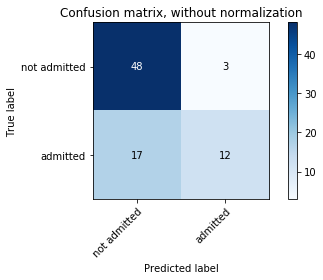

In [46]:
plot_confusion_matrix(y_true=y_test , y_pred=rf_predictions, classes=['not admitted','admitted'])
report = classification_report(y_true=y_test , y_pred=rf_predictions)
print(report)

## Part 5: Tuning the Forest

"While model parameters are learned during training — such as the slope and intercept in a linear regression — hyperparameters must be set by the data scientist before training." - William Koehrsen
<br>


In [ ]:
# Number of trees in random forest
n_estimators = [1000, 2000, 3000]

# Number of features to consider at every split
max_features =  ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [None, 1, 2, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


In [ ]:
#create a grid
cv_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf
          }

In [ ]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


*This will take some time to run....*

In [ ]:
# run grid search
from sklearn.model_selection import GridSearchCV
from time import time

rf = RandomForestRegressor(max_depth=2, random_state=10)
grid_search = GridSearchCV(rf, param_grid=cv_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train.ravel())

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

In [ ]:
# Predict 
grid_predictions = rf_simple.predict(X_test_simple)

# Format and print
print(pd.DataFrame({'predictions': grid_predictions, 'actual values': y_test}).head())

In [ ]:
# Calculate accuracy (RMSE)
rf_grid_rmse = np.sqrt(mean_squared_error(y_test, grid_predictions))

# Format and print
print("Our tree's RMSE is {:.2} or ${:,.2f}.".format(rf_grid_rmse, rf_grid_rmse*1000))

<br>
<br>
## Resources 

<img src="images/data_science.jpg" width="400" height="400" align="right"/>

### Introductory Topics ###

*How to Become a Data Science* <br>
https://towardsdatascience.com/how-to-learn-data-science-if-youre-broke-7ecc408b53c7 <br>
https://www.class-central.com/subject/data-science <br>

*Jupyter* <br>
https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html

*Pandas* <br>
https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python


### Deep Dive Topics ###

*Information Gain and Entropy* <br>
https://www.saedsayad.com/decision_tree.htm <br>

*Ensemble Models - The Power of Crowds and Aggregated Predictions* <br>
https://www.npr.org/sections/money/2015/08/07/429720443/17-205-people-guessed-the-weight-of-a-cow-heres-how-they-did <br>


*Accuracy, Precision, Recall, F1* <br>
https://towardsdatascience.com/precision-vs-recall-386cf9f89488 <br>
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c <br>

*Random Forest - Feature Information* <br>
http://explained.ai/rf-importance/index.html <br>
http://www.scikit-yb.org/en/latest/api/features/importances.html <br>

*Grid Search* <br>
https://www.quora.com/Machine-Learning-How-does-grid-search-work <br>


### General ####

*Good Reads* <br>
https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6 <br>
https://medium.com/machine-learning-for-humans/why-machine-learning-matters-6164faf1df12 <br>
https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d <br>
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 <br>
https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained <br>
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

*Data Source* <br>
https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html